In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import json
import random
import copy

from dsets import ClinicalDiseaseDataset

/home/ubuntu/dev/medical-gpt-interpretability/ENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")

In [14]:
with_context = False
dataset = ClinicalDiseaseDataset('../data', with_context=with_context)
replacement_subjects = json.load(open('../data/disease_keywords.json'))

Loaded dataset with 50 samples


In [15]:
dataset[0], replacement_subjects["0"]

({'id': 0,
  'subject': ['strabismus', 'amblyopia', 'visual acuity', 'eye disorders'],
  'attribute': 'no',
  'question': 'landolt c and snellen e acuity: differences in strabismus amblyopia?',
  'context': 'assessment of visual acuity depends on the optotypes used for measurement. the ability to recognize different optotypes differs even if their critical details appear under the same visual angle. since optotypes are evaluated on individuals with good visual acuity and without eye disorders, differences in the lower visual acuity range cannot be excluded. in this study, visual acuity measured with the snellen e was compared to the landolt c acuity.100 patients (age 8 - 90 years, median 60.5 years) with various eye disorders, among them 39 with amblyopia due to strabismus, and 13 healthy volunteers were tested. charts with the snellen e and the landolt c (precision vision) which mimic the etdrs charts were used to assess visual acuity. three out of 5 optotypes per line had to be corre

In [9]:
def get_answer_prob(prompt, answer):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    # Forward pass to get the logits
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

    # Extract logits at the last position (where answer starts)
    logits = outputs.logits[0, -1, :]  # Shape: [vocab_size]

    # Get token IDs for "Yes", "No", and "Maybe"
    yes_token_id = tokenizer(" Yes", add_special_tokens=False)["input_ids"][0]
    no_token_id = tokenizer(" No", add_special_tokens=False)["input_ids"][0]
    maybe_token_id = tokenizer(" Maybe", add_special_tokens=False)["input_ids"][0]

    # Extract logits for the specific tokens
    answer_logits = logits[[yes_token_id, no_token_id, maybe_token_id]]

    # Convert logits to probabilities
    answer_probs = F.softmax(answer_logits, dim=0)

    if answer == 'yes':
        return answer_probs[0].item()
    elif answer == 'no':
        return answer_probs[1].item()
    elif answer == 'maybe':
        return answer_probs[2].item()
    

In [10]:
def make_corrupt_prompt(data):
    clean_prompt = data['prompt']
    subject_arr = data['subject']

    # first choose a random idx then choose a random subject
    idx = random.randint(0, len(replacement_subjects) - 1)
    if idx == data['id']:
        idx = (idx + 1) % len(replacement_subjects)
    new_subject_arr = replacement_subjects[str(idx)]
    new_subject = random.choice(new_subject_arr)

    print('original subject:', subject_arr)
    print('new subject:', new_subject)
    for subject in subject_arr:
        corrupt_prompt = clean_prompt.replace(subject, new_subject)
    return corrupt_prompt

In [16]:
prob_diffs = []
for i in range(len(dataset)):
    data = dataset[i]
    clean_prompt = data['prompt']
    clean_prob = get_answer_prob(clean_prompt, data['attribute'])

    corrupted_prompt = make_corrupt_prompt(data)
    corrupted_prob = get_answer_prob(corrupted_prompt, data['attribute'])

    prob_diffs.append(clean_prob - corrupted_prob)

original subject: ['strabismus', 'amblyopia', 'visual acuity', 'eye disorders']
new subject: young age
original subject: ['colectomy', 'hirschsprung disease']
new subject: deaths
original subject: ['double-balloon enteroscopy', 'community', 'female', 'intestinal diseases']
new subject: pap smear
original subject: ['sleep disorders', 'sleep', 'self-reports', 'prevalence', 'self-reported']
new subject: hdl
original subject: ['mutations', 'hdl', 'coronary heart disease', 'cholesterol', 'hdl cholesterol']
new subject: vegf
original subject: ["academic children's hospital", "general and academic children's hospital", 'hospital', 'children', 'young age', 'hospital efficiency', 'length of stay', 'pediatric', 'admissions']
new subject: female prostitutes
original subject: ['family history', 'primary care physicians', 'electronic health records']
new subject: asphyxia
original subject: ['palliative care', 'opioid administration', 'breathlessness', 'opioid']
new subject: sleep
original subject: 

In [17]:
def plot_histogram(data, title):
    plt.hist(data, bins=20)
    plt.title(title)
    plt.xlabel('Answer Token Probability Difference')
    plt.ylabel('Frequency')
    plt.show()

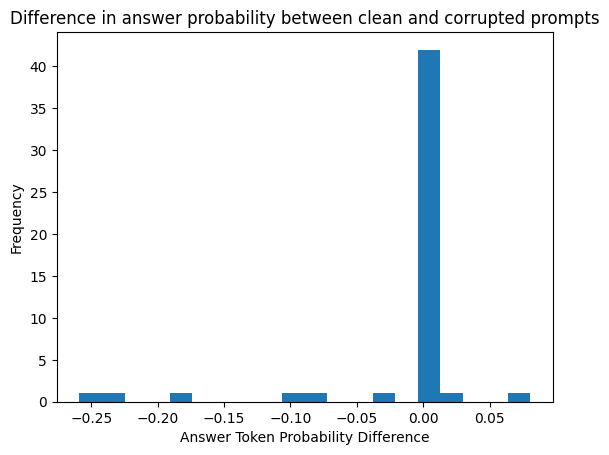

In [18]:
title = 'Difference in answer probability between clean and corrupted prompts'
if with_context:
    title += ' (with context)'
plot_histogram(prob_diffs, title)